# CountVectorizer 모듈로 전처리
* 각 html당 등장 단어수를 기반으로 one-hot encoding 파일 생성
# RandomForest 분류기로 모델링

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
train = pd.read_csv('train_data.csv')
train.head()

,html,label,path
0,Best Financial Service - #1 shop to ear...,1,222222222xn2ozdb2mjnkjrvcopf5thb6la6yj24jvyjqr...
1,"bitcoin, bitcoin generator, free bitcoin ...",1,22222uswoye6ve7ixbgkwlvynjrvsg4od2qrs6zs5pbtpr...
2,Underground Market - Prepaid & Cloned Cards...,1,2222fxq4xfkvilzdihu5ybce7ztf66fr6c7ub3enabg5iy...
3,Stolen Cards | Plastic Sharks ...,1,22c7nfj32ujbnymoo2zh64il46j3k2vuo7kryj757hkhpa...
4,Best Amazon Gift Card ...,0,22cwxace6a4cu2yzti4i2x2gikl4wpqr3nz36jlpxoosgi...


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    2494 non-null   object
 1   label   2494 non-null   int64 
 2   path    178 non-null    object
dtypes: int64(1), object(2)
memory usage: 58.6+ KB


In [ ]:
# label과 html 분리
input = train['html']
target = train['label']
print('html개수 확인 : ',len(input))
print('label개수 확인 : ',len(target))

html개수 확인 :  2494
label개수 확인 :  2494


In [ ]:
nltk.download('words')
nltk.download('stopwords')
words = set(nltk.corpus.words.words())
processed_html = []
for num in range(2494):
  a = input[num]
  sent = re.sub('[^a-zA-Z0-9\$.]+', ' ', str(a))
  edit = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
          if w.lower() in words or not w.isalpha())  
  edit = edit.lower()
  edit = edit.split()
  ps = PorterStemmer()
  edit = [ps.stem(word) for word in edit if not word in set(stopwords.words('english'))]
  edit = ' '.join(edit)
  processed_html.append(edit)
len(processed_html)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2494

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()   
feature = cv.fit_transform(processed_html).toarray()
feature

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 위 feature관련...
# I love Korea  
# I don't like Japan 이라는 문장이 있다고 가정
* 단어별로 쪼개주면
  * I  / love / Korea / don't / like /  Japan

# 이후
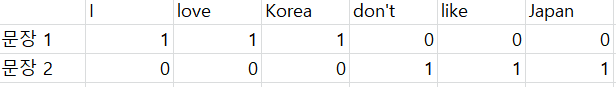



In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(feature,target,test_size=0.2,random_state=42,stratify=target)

In [ ]:
# GridSearchCV로 최적옵션 체크
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators' : [500,1000,2000,3000,4000,5000,10000],
              'max_depth' : [4,5,6,7,8],
              'criterion' : ['entropy','gini']}
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,param_grid=param_grid,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
# 최적 옵션
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 3000}
0.8586466165413533


In [ ]:
rfc_2 = RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=3000,max_depth=8,criterion='gini')
rfc_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix
pred = rfc_2.predict(X_valid)
cm = confusion_matrix(y_valid,pred)
print(cm)   # 정확도를 보려면 237, 197이 잘 분류했다는 뜻

[[237   8]
 [ 57 197]]


In [ ]:
test = pd.read_csv('test_data.csv')
test['label'] = test['label'].apply(lambda x: int(x))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    1726 non-null   object
 1   label   1726 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.1+ KB


In [ ]:
input_2 = test['html']

In [ ]:
nltk.download('words')
nltk.download('stopwords')
words = set(nltk.corpus.words.words())
processed_html_score = []
for num in range(1726):
  a = input_2[num]
  sent_2 = re.sub('[^a-zA-Z0-9\$.]+', ' ', str(a))
  edit_2 = " ".join(w for w in nltk.wordpunct_tokenize(sent_2) \
          if w.lower() in words or not w.isalpha())  
  edit_2 = edit_2.lower()
  edit_2 = edit_2.split()
  ps_2 = PorterStemmer()
  edit_2 = [ps_2.stem(word) for word in edit_2 if not word in set(stopwords.words('english'))]
  edit_2 = ' '.join(edit_2)
  processed_html_score.append(edit_2)
len(processed_html_score)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1726

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv_2 = CountVectorizer(max_features=28417)  # train_data의 단어개수와 동일하게 설정
feature_score = cv_2.fit_transform(processed_html_score).toarray()

In [ ]:
result = rfc_2.predict(feature_score)
cm_2 = confusion_matrix(test['label'],result)
print(cm_2)

[[ 346    1]
 [1374    5]]


# test_data에 대해 동일 전처리 수행 후
# Predict 결과 349/1726 = 20%의 정확도